In [ ]:
!pip install transformers datasets evaluate accelerate peft==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaModel, RobertaTokenizer, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, AutoPeftModelForSequenceClassification
from datasets import Dataset
from torch.utils.data import DataLoader

import evaluate
from tqdm import tqdm

In [ ]:
BASIC_PATH = '/content/gdrive/MyDrive/ML/projects/feedback-prize/'

In [ ]:
data = pd.read_csv(BASIC_PATH+'data/train_2021.csv')

In [ ]:
data

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...


In [ ]:
data['discourse_type'].value_counts()

,count
discourse_type,
Claim,50208
Evidence,45702
Position,15419
Concluding Statement,13505
Lead,9305
Counterclaim,5817
Rebuttal,4337


In [ ]:
data.iloc[1, 4]

'They are some really bad consequences when stuff happens when it comes to a phone.'

In [ ]:
data['discourse_len'] = data['discourse_text'].apply(lambda x: len(x.split(' ')))

In [ ]:
sns.set(style="whitegrid")

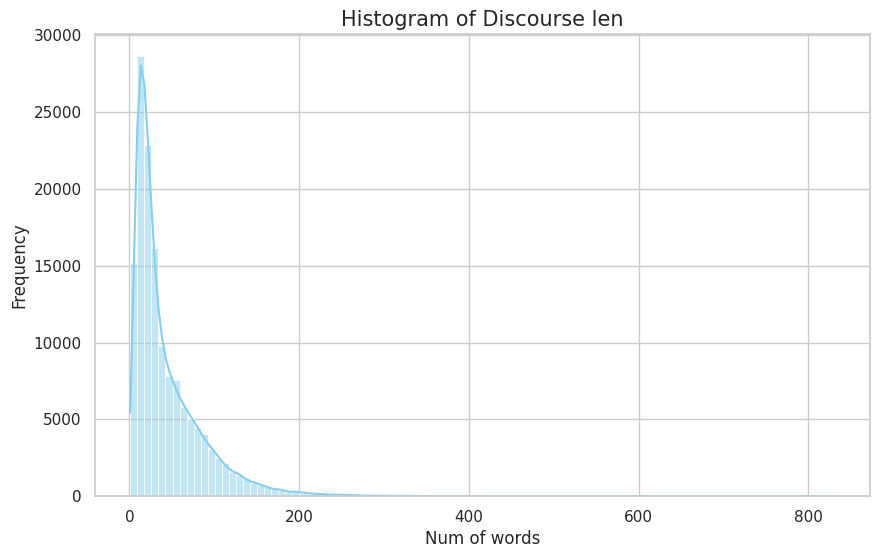

In [ ]:
plt.figure(figsize = (10, 6))
sns.histplot(data['discourse_len'], bins = 100, kde = True, color = 'skyblue')

plt.title('Histogram of Discourse len', fontsize = 15)
plt.xlabel('Num of words', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

## Preprocessing

In [ ]:
dataset = Dataset.from_pandas(data[['discourse_text',	'discourse_type']])

In [ ]:
dataset

Dataset({
    features: ['discourse_text', 'discourse_type'],
    num_rows: 144293
})

In [ ]:
BASE_MODEL = 'roberta-base'
TRAINED_TOKENIZER = 'roberta-base-tokenizer'
PEFT_MODEL = 'roberta-base-peft'

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(BASE_MODEL, clean_up_tokenization_spaces = True, use_fast = False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def preprocess(data):
    tokenized = tokenizer(data['discourse_text'], max_length = 200, truncation = True, padding = True)
    return tokenized

In [ ]:
tokenized_dataset = dataset.map(preprocess, batched = True, remove_columns = ['discourse_text'])

Map:   0%|          | 0/144293 [00:00<?, ? examples/s]

In [ ]:
class_names = list(set(data['discourse_type']))
class_names.sort()

In [ ]:
label_to_id = {label: i for i, label in enumerate(class_names)}
id_to_label = {i: label for i, label in enumerate(class_names)}

In [ ]:
def encode_labels(data):
    data['label'] = label_to_id[data['discourse_type']]
    return data

In [ ]:
tokenized_dataset = tokenized_dataset.map(encode_labels, remove_columns = ['discourse_type'])

Map:   0%|          | 0/144293 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 144293
})

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size = 0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']
eval_dataset = test_dataset.shard(num_shards = 2, index = 0)
test_dataset = test_dataset.shard(num_shards = 2, index = 1)

## Train model with LORA using PEFT library

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'pt')

In [ ]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience = 2,
)

In [ ]:
training_args = TrainingArguments(
    output_dir = './results',
    eval_strategy = 'steps',
    eval_steps = 500,
    learning_rate = 5e-5,
    num_train_epochs = 2,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss'
)

# Function to get the Trainer
def get_trainer(model):
    return Trainer(
        model = model,
        args = training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        data_collator = data_collator,
    )

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels = len(class_names), id2label = id_to_label, label2id = label_to_id)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
peft_config = LoraConfig(task_type = "SEQ_CLS",
                         inference_mode = False,
                         r = 8,
                         lora_alpha = 16,
                         lora_dropout = 0.2)

peft_model = get_peft_model(model, peft_config)

In [ ]:
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.2, inplace=False)
                    )
                    (lora_A): ModuleD

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 890,887 || all params: 125,541,902 || trainable%: 0.7096


In [ ]:
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight: torch.Size([8, 768])
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight: torch.Size([768, 8])
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight: torch.Size([8, 768])
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight: torch.Size([768, 8])
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight: torch.Size([8, 768])
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight: torch.Size([768, 8])
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight: torch.Size([8, 768])
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.weight: torch.Size([768, 8])
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight: torch.Size([8, 768])
base_model.model.roberta.encoder.layer.2.atten

In [ ]:
peft_trainer = get_trainer(peft_model)

In [ ]:
peft_trainer.train()

Step,Training Loss,Validation Loss
500,1.412700,1.184834
1000,1.095500,0.930435
1500,0.925000,0.836441
2000,0.853800,0.786582
2500,0.835400,0.765771
3000,0.789600,0.797252
3500,0.776700,0.713006
4000,0.756600,0.710757
4500,0.746500,0.709544
5000,0.741200,0.691028


TrainOutput(global_step=14430, training_loss=0.7650730569248636, metrics={'train_runtime': 9660.6611, 'train_samples_per_second': 23.898, 'train_steps_per_second': 1.494, 'total_flos': 2.39759729570592e+16, 'train_loss': 0.7650730569248636, 'epoch': 2.0})

Inference on test data

In [ ]:
# Initialize evaluation metrics
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')

def evaluate_model(inference_model, dataset):

    # Set the model to evaluation mode
    inference_model.eval()

    # Move the model to the appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inference_model.to(device)

    test_dataloader = DataLoader(dataset, batch_size=4, collate_fn=data_collator)

    # Iterate over the test data
    for batch in tqdm(test_dataloader):
        # Move batch to the appropriate device
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = inference_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        predictions = outputs.logits.argmax(dim=-1)
        references = batch['labels']

        # Add batch to the metrics
        accuracy_metric.add_batch(predictions=predictions, references=references)
        f1_metric.add_batch(predictions=predictions, references=references)
        precision_metric.add_batch(predictions=predictions, references=references)
        recall_metric.add_batch(predictions=predictions, references=references)

    # Compute and print the metrics
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute(average='weighted')
    precision = precision_metric.compute(average='weighted')
    recall = recall_metric.compute(average='weighted')

    print(f"Accuracy: {accuracy['accuracy']}")
    print(f"F1 Score: {f1['f1']}")
    print(f"Precision: {precision['precision']}")
    print(f"Recall: {recall['recall']}")

In [ ]:
evaluate_model(peft_model, test_dataset)

100%|██████████| 3608/3608 [03:06<00:00, 19.31it/s]


Accuracy: 0.7704622634971239
F1 Score: 0.7690201120602141
Precision: 0.7713020014455598
Recall: 0.7704622634971239


In [ ]:
# tokenizer.save_pretrained(BASIC_PATH+TRAINED_TOKENIZER)
# peft_model.save_pretrained(BASIC_PATH+PEFT_MODEL)
# torch.save(peft_model.state_dict(), BASIC_PATH + 'roberta_base_peft_weights.pth')

## Sanity check that the model has been saved correctly

In [ ]:
PEFT_MODEL_PATH = BASIC_PATH+PEFT_MODEL
TOKENIZER_PATH = BASIC_PATH+TRAINED_TOKENIZER

In [ ]:
inference_model = AutoPeftModelForSequenceClassification.from_pretrained(PEFT_MODEL_PATH, id2label = id_to_label, label2id = label_to_id)
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
evaluate_model(inference_model, test_dataset)

100%|██████████| 3608/3608 [03:13<00:00, 18.60it/s]


Accuracy: 0.7704622634971239
F1 Score: 0.7690201120602141
Precision: 0.7713020014455598
Recall: 0.7704622634971239


Compare against base pre-trained model

In [ ]:
base_inference_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label = id_to_label, label2id = label_to_id)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
evaluate_model(base_inference_model, test_dataset)

100%|██████████| 3608/3608 [02:58<00:00, 20.19it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.035830618892508145
F1 Score: 0.0048420278831806315
Precision: 0.005187610626257461
Recall: 0.035830618892508145


Load the full weights and compare (another sanity check)

In [ ]:
inference_model_2 = get_peft_model(base_inference_model, peft_config)

In [ ]:
inference_model_2.load_state_dict(torch.load(BASIC_PATH + 'roberta_base_peft_weights.pth')) # if you saved the weights above (not included in the current repository)

<ipython-input-51-b97ede3d2ca7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_model_2.load_state_dict(torch.load(BASIC_PATH + 'roberta_base_peft_weights.pth'))


<All keys matched successfully>

In [ ]:
evaluate_model(inference_model_2, test_dataset)

100%|██████████| 3608/3608 [03:23<00:00, 17.71it/s]


Accuracy: 0.7704622634971239
F1 Score: 0.7690201120602141
Precision: 0.7713020014455598
Recall: 0.7704622634971239
